<a href="https://colab.research.google.com/github/ohhongseok/ML-DeepLearning/blob/main/7/7-3/%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 키워드
 - 드롭아웃
 - 콜백
 - 조기종료

이번장에서는 케라스 API를 활용하여 모델을 훈련하는데 필요한 다양한 도구들을 알아보자

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input,train_target),(test_input,test_target)= \
keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled,val_scaled,train_target,val_target = train_test_split(
    train_scaled,train_target,test_size=0.2, random_state=42,)

In [2]:
# 모델 add 함수 만들기, 여기에서는 함수로 모델 만드는 함수를 정의함
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [3]:
model=model_fn() # 간단하게 함수선언으로 모델 생성

In [4]:
model.summary() # 모델 확인하기

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 컴파일 후 학습 진행
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
# verbose=0 의 의미 >  
# 0일 경우 : 훈련중 정보를 보여주지 않음(epoch 진행과정)
# 1일 경우 : 훈련의 진행도를 보여주는 진행막대를 보여줌(default)
# 2일 경우 : 훈련중 미니배치마다 손실 정보를 출력함
history = model.fit(train_scaled,train_target,epochs=5,verbose=0)

In [6]:
# 훈련의 측정이 담겨있는 history 객체의 history 딕셔너리
print(history.history.keys()) 
# 손실과 정확도의 정보가 담겨있다.

dict_keys(['loss', 'accuracy'])


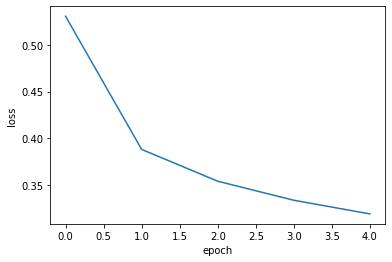

In [7]:
# 각 에포크 마다 손실과 정확도를 그래프화 해서 나타내기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

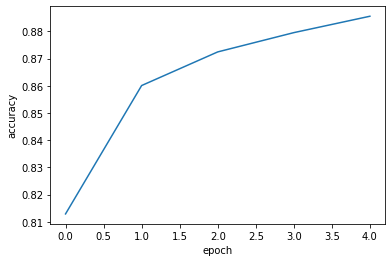

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

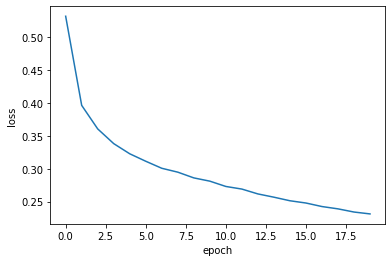

In [9]:
# 에포크 횟수를 늘려서 loss 측정
# 각 에포크 마다 손실과 정확도를 그래프화 해서 나타내기
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
history = model.fit(train_scaled,train_target,epochs=20,verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 검증 손실
 - 앞서 4장에서 에포크와 과대, 과소적합간의 관계를 알아 보았다
  > 에포크의 횟수가 적은 경우 모델이 훈련세트를 덜 학습함 -> 과소모델일 가능성이 높다.<br>
  에포크의 횟수가 많은 경우 모델이 훈련세트에 너무 잘 맞음 -> 테스트 점수에는 나쁜 과대모델일 가능성이 높다.
 - 인공신경망또한 일종의 경사하강법을 사용하기에, 동일한 개념이 여기에도 적용된다.
 - 에포크의 경우 과대 / 과소적합을 파악하려면 훈련세트와 검증세트의 점수 모두를 파악해야 한다.

# 신경망과 정확도, 손실함수의 관계
 - 앞장에서는 모델의 정확도에 대해 accuracy를 판단하였다.
 - 하지만, 인공신경망에서는 모델이 최적화 하는 대상이 정확도가 아닌 손실함수이다.
 - 따라서 모델이 잘 훈련되었는지 판단하려면 ***손실함수***의 값을 확인하는것이 더 중요하다.


In [10]:

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
# 에포크마다 검증손실을 계산하기 위해 케리스모델 fit 과정에서 검증데이터를 전달할 수 있다.
# fit 메서드에서 validation_data 파라미터를 통해 검증데이터와 검증 타겟을 넣어 
# 매 에포크 마다 검증손실을 계산할 수 있다.
history = model.fit(train_scaled,train_target,epochs=20,verbose=0
                    ,validation_data=(val_scaled,val_target))


In [11]:
print(history.history.keys())
# 이전의 key 값과 다르게 검증데이터의 정확도와 손실값이 들어있음

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


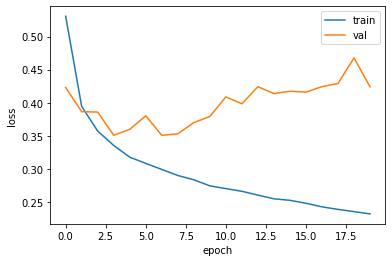

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# 3번째 에포크 부터 과대적합 모델이 만들어지는 구간
# 이 구간을 3장에서 배운 규제를 통해 값을 늦춰보자 

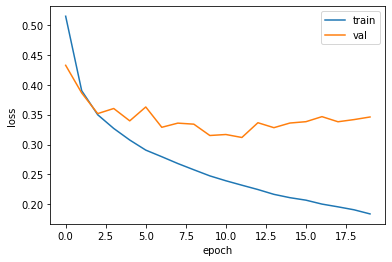

In [13]:
# 이번장에서는 옵티마이저를 통해 규제를 진행

model = model_fn()

# 옵티마이저 adam 을 활용하여 진행
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
history = model.fit(train_scaled,train_target,epochs=20,verbose=0
                    ,validation_data=(val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()
# adam 옵티마이저를 통해 그려본 검증 및 트레이닝 데이터의 손실값
# 앞선 결과보다 더 나은 결과를 내놓았고 adam 옵티마이저가 이 데이터셋에
# 잘 맞음을 의미함

# 드롭아웃
 - 신경망에서 사용하는 대표적인 규제방식
 - 훈련 과정중 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는 방법
 - 이전층의 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는것을 줄일 수 있고 모든 입력에 대해 주의를 기울여야 함
 - 얼마나 많은 뉴런을 드롭아웃 할지는 사용자가 정해야 하는 하이퍼 파라미터이다.
 - 케라스에서는 `keras.layers.Dropout()` 클래스로 제공해 준다.

In [14]:
# Dropout(ratio) 를 사용하면, ratio (여기에서는 30%) 만큼의
# Dropout이 발생해 특정 뉴런은 꺼지고 학습을 돌리게 된다. 
model = model_fn(keras.layers.Dropout(0.3))
model.summary()
# summary() 에서 살펴보면 은닉층 뒤에 드롭아웃이 추가되었고, 
# 훈련되는 모델 파라미터가 없이 규제만 하는것을 알 수 있다. 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


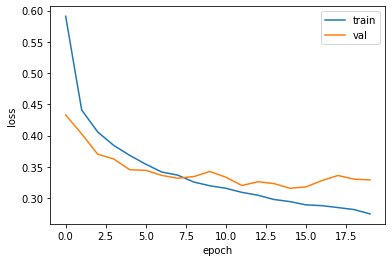

In [15]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
history = model.fit(train_scaled,train_target,epochs=20,verbose=0
                    ,validation_data=(val_scaled,val_target))
# keras에서는 모델의 훈련 시에만 Dropout을 진행하기에
# 모델을 훈련한 후 평가 및 사용을 할때에는 Dropout을 적용하지 않는다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()
# 과대적합도 확실히 줄고 손실의 감소 또한 상승하지 않고 어느정도 유지되는 값으로 나옴
# bt 20번의 에포크로 어느정도 과대적합이 되었기에, 10번으로 에포크를 줄이고 훈련

# 모델의 저장과 복원
 - why? 
  > 학습자가 이 모델을 나중에 사용하려 할때에는 다시 학습 및 파라미터를 조정할 필요 없이 저장후 불러오기를 하기 위함

In [16]:
# 모델의 저장과 복원

# 드롭아웃 0.3에 에포크 10번으로 제한한 모델
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
history = model.fit(train_scaled,train_target,epochs=10,verbose=0
                    ,validation_data=(val_scaled,val_target))

In [17]:
# 훈련된 파라미터 저장
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 훈련된 모델의 파라미터를 저장
model.save_weights('model-weight.h5')

In [19]:
# 모델의 구조와 파라미터를 함께 저장
model.save('model-whole.h5')

In [20]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jan 13 03:18 model-weight.h5
-rw-r--r-- 1 root root 982664 Jan 13 03:18 model-whole.h5


# 저장한 모듈 사용하기
 - case1). 훈련하지 않은 새로운 모델을 만들고, model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어서 사용
 - case2). model-whole.h5 파일에서 새로운 모델을 만들어 바로 사용

In [21]:
# case1). 
# 훈련하지 않은 새로운 모델을 만들고 
model = model_fn(keras.layers.Dropout(0.3))
# 이전에 만든 파라미터 적재(load_weight() 사용)
model.load_weights('model-weight.h5')

#########################################################
# load_weight() 사용시 주의사항
# 해당 모델을 만들었을 때의 똑같은 레이어 및 환경으로 만들어야함
#########################################################


In [22]:
# 모델 예측 진행
# 케라스 다중분류의 경우 예측의 결과는
# 각 클래스별 확률을 반환함
# 따라서 이 예제에서는 총 10개의 클래스에 대한 확률값을 반환함
import numpy as np
# 모델의 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 사용
val_labels = np.argmax(model.predict(val_scaled),axis=-1)
print(np.mean(val_labels == val_target))

0.87775


In [23]:
# case2).
# 모델 전체를 읽은 후 검증세트를 통해 정확도 측정
# 위와 다르게 모델 전치를 읽기 위해 load_model() 클래스 사용
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3376 - accuracy: 0.8777


[0.33757761120796204, 0.8777499794960022]

# 위의 과정 요약
 - 모델의 에포크 훈련 기간동안 과대적합이 되는 지점을 찾음(loss)
 - 이후 위에서 나온 결과값을 통해 과대적합이 되는 지점의 바로 전의 에포크 만큼으로 다시 훈련함
 - 위 과정은 결과적으로 모델을 두번 훈련시킨 것
 - 따라서 모델을 두번씩 훈련하지 않고 한번에 끝내기 위해 ***콜백*** 사용

# 콜백
 - 훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 `keras.callbacks` 패키지 아래 클래스 이다.
 - 이 패키지 아래 ModelCheckpoint 콜백은 에포크마다 모델을 저장한다.
 - 이후 save_best_only=True를 하게 되면 손실함수가 가장 작은 모델을 저장하게 된다.(best-model.h5 에다가)

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True) #save_best_only=True 손실함수가 가장 작은 값을 저장 

# 저장한 체크포인트를 fit 안에 callbacks=[checkpoint_cb] 리스트로 전달하여 사용한다.
model.fit(train_scaled,train_target,epochs=20,verbose=0
                    ,validation_data=(val_scaled,val_target),
          callbacks=[checkpoint_cb])

In [25]:
# 모델을 저장하였기에 모델 자체를 불러오기만 하면 끝(앞서 했던 load_model())
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled,val_target) # 앞서서 사용한 결과값이 그대로 출력
# 두번 학습할 필요없이 저장

375/375 [==============================] - 1s 2ms/step - loss: 0.3222 - accuracy: 0.8845


[0.322223037481308, 0.8845000267028809]

# 조기종료
 - 앞서서 콜백을 통해 두번의 학습과정 없이 한번에 검증과 결과를 냄
 - 하지만, 여전히 20번의 에포크 훈련을 진행함, -> optimal한 epoch 사이즈는 10
 - 따라서 10번 이후의 에포크는 리소스 낭비이므로, 과대적합이 시작되기전에 훈련을 미리 중지해야함
 - 이러한 방법을 ***조기종료*** 라고 함
 - 케라스에서 조기종료를 위한 `EarlyStopping` 을 사용 

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',
                                                save_best_only=True)
# EarlyStopping의 patience 매개변수는 검증점수가 향상되지 않더라도 참을 에포크 횟수임
# patience=2 일 경우 2번 연속 검증점수가 향상되지 않을경우,(loss율이 작아지는것이 없을 경우)
# 훈련을 중지함 -> loss의 값이 작아졌다가 커지는 순간
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# 저장한 체크포인트를 fit 안에 callbacks=[checkpoint_cb, early_stopping_cb] 리스트로 전달하여 사용한다.
model.fit(train_scaled,train_target,epochs=20,verbose=0
                    ,validation_data=(val_scaled,val_target),
          callbacks=[checkpoint_cb, early_stopping_cb])

In [28]:
# 훈련이 끝난 후, early_stopping_cb 객체의 stopped_epoch를 통해 몇번째 에포크에서 훈련이 멈췄는지 확인이 가능
print(early_stopping_cb.stopped_epoch)

7


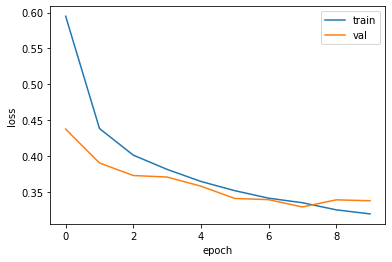

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [30]:
# 조기종료로 얻은 모델을 검증세트에 대해 성능 확인하기
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3377 - accuracy: 0.8745


[0.3377428948879242, 0.8744999766349792]

# 이번장 마무리
 - 드롭아웃 : 랜덤하게 Dense층의 노드중 일부를 꺼서 과적합을 예방